# Example: Markov Stability with PyGenStability

This example illustrate how to use pygenstability for multiscale community detection with Markov Stability algorithm.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp

import pygenstability as pgs
from pygenstability import plotting
from pygenstability.pygenstability import evaluate_NVI

from multiscale_example import create_graph

We first create a stochastic block model graph with some planted partitions at different scales.

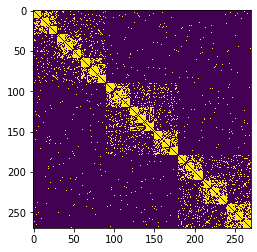

In [2]:
A, coarse_scale_id, middle_scale_id, fine_scale_id = create_graph() 

# Create nx graph
G = nx.from_numpy_array(A)

# Compute spring layout
pos_G = nx.layout.spring_layout(G, seed=1)


# plot matrix
plt.figure()
plt.imshow(A, interpolation="nearest")


We then run pygenstability with the continuous_combinatoral constructor, which corresponds to using the combinatorial Laplacian matrix in the Markov Stability.
The number and range of markov times, or scales can be specified with max_scale, min_scale and n_scales. They are in log scale by default.
The number of Louvain evaluations is specified with n_tries argument.

Other options are available, see the documentation: https://barahona-research-group.github.io/PyGenStability/

In [3]:
# run markov stability and identify optimal scales
results = pgs.run(
    sp.csgraph.csgraph_from_dense(A),
    min_scale=-1.5,
    max_scale=0.5,
    n_scale=50,
    n_tries=20,
    constructor="continuous_combinatorial",
    n_workers=4
)

INFO:pygenstability.pygenstability:Precompute constructors...
100%|██████████| 50/50 [00:51<00:00,  1.02s/it]
INFO:pygenstability.pygenstability:Optimise stability...
100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
INFO:pygenstability.pygenstability:Apply postprocessing...
100%|██████████| 50/50 [00:02<00:00, 20.80it/s]
INFO:pygenstability.pygenstability:Compute ttprimes...
INFO:pygenstability.pygenstability:Identify optimal scales...


The standard plot to analyse multiscale clustering results in plot_scan, which shows various informations, such as the number of cluster, stability, normalized variation of information (NVI) between Louvain evalutions, and accros scales (NVI(t, t')). Finally, if computed a scale selection algorithm highlights most robust scales.

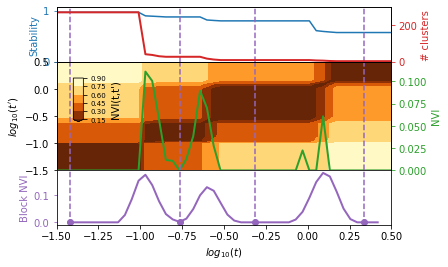

In [4]:
# plots resultsWe can then plot some selected partitions from the optimial scale detection algorithm, but here, we expect only one scale to be meaningful. See https://github.com/barahona-research-group/PyGenStability/blob/master/examples/multiscale_example.py for a more complex a multiscale example.
_ = plotting.plot_scan(results, figure_name=None)

We can then plot the optimall partitions determined with the scale selection algorithm.

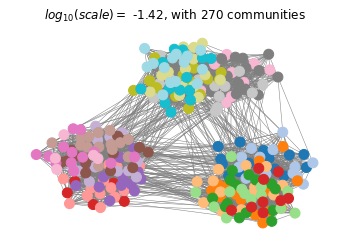

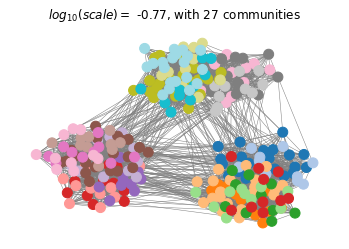

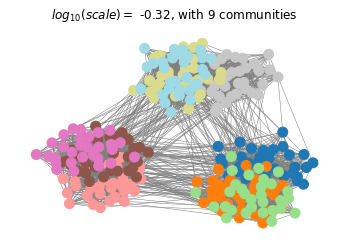

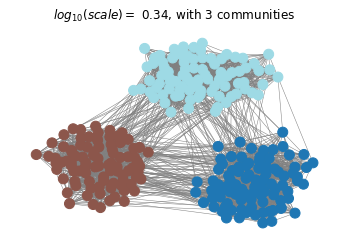

In [5]:
# plot optimal partitions
plotting.plot_optimal_partitions(G,results)

Finally, we compare the selected partitions with the ground-truth planted partitions using the Normalised Variation of Information (NVI) and observe that MS analysis with optimal scale selection recovers the planted multiscale structure of the network.

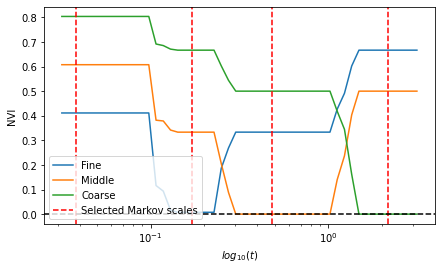

In [6]:
# compare MS partitions to ground truth with NVI
def _get_NVI(ref_ids):
    return [
        evaluate_NVI([0, i + 1], [ref_ids] + results["community_id"])
        for i in range(len(results["scales"]))
    ]

NVI_scores_fine = _get_NVI(fine_scale_id)
NVI_scores_middle = _get_NVI(middle_scale_id)
NVI_scores_coarse = _get_NVI(coarse_scale_id)
scales = results["scales"]

# plot NVI scores
fig, ax = plt.subplots(1, figsize=(7, 4))
ax.plot(scales, NVI_scores_fine, label="Fine")
ax.plot(scales, NVI_scores_middle, label="Middle")
ax.plot(scales, NVI_scores_coarse, label="Coarse")

# plot selected partitions
selected_partitions = results["selected_partitions"]
ax.axvline(
    x=results["scales"][selected_partitions[0]],
    ls="--",
    color="red",
    label="Selected Markov scales",
)
for i in selected_partitions[1:]:
    ax.axvline(x=results["scales"][i], ls="--", color="red")

ax.set(xlabel=r"$log_{10}(t)$", ylabel="NVI")
plt.axhline(0, c="k", ls="--")
ax.legend(loc=3)
plt.xscale("log")
